# nichefinder — Simulated Data Tutorial

This notebook demonstrates the **nichefinder** workflow on a small simulated
spatial transcriptomics dataset (the *fig2c* benchmark from the NiCo 
paper[1]). The data contain ~1200 simulated cells distributed across 6 
ground-truth cell-type niches (T0–T5).

**Steps:**
1. Load spatial coordinates and cell-type labels from CSV files  
2. Build a spatial kNN graph  
3. Aggregate neighbourhood cell-type compositions  
4. Discover niches with NMF
5. Visualise results

## Imports

In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

# Add the repo root so the local nichefinder package is importable when running
# the notebook outside of an installed environment.
sys.path.insert(0, str(Path("..").resolve()))
import nichefinder as nf

sc.settings.verbosity = 1  # warnings / errors

## 1. Load Example Data

Two CSV files are stored in `tests/data/`. Each integer label maps to a named cell type T0–T5.

In [2]:
DATA_DIR = Path("../tests/data")

# Spatial coordinates (index = cell barcode, columns = x, y)
positions = pd.read_csv(DATA_DIR / "tissue_positions_list.csv", header=None, index_col=0)
positions.columns = ["x", "y"]

# Cell-type integer labels
labels = pd.read_csv(DATA_DIR / "save_clusterid_0.csv", header=0, index_col=0)

print(f"cells: {len(positions)}")
positions.head()

cells: 1200


,x,y
0,,
cell0,-47.1687,-48.4782
cell1,-40.9566,47.6542
cell2,-33.1988,49.7143
cell3,-31.2584,-49.0793
cell4,-29.8418,46.9326


Build an AnnData object from the simulated data.

In [3]:
ad = sc.AnnData(positions)
ad.obsm["spatial"] = positions.to_numpy().astype(float)
ad.obs["cell_type"] = labels.iloc[:, 0].map(lambda x: f"T{x}").values

ad

AnnData object with n_obs × n_vars = 1200 × 2
    obs: 'cell_type'
    obsm: 'spatial'

Because we have added cell type labels manually and `nf.aggregate_neighbors` reads cell-type probabilities from `ad.obsm` and
looks up the key and label names via `ad.uns["label_transfer"]`, we add this information to `ad.uns` manually, too. Here, because the ground-truth labels are known exactly, we use one-hot
encoded indicator vectors as (hard) "probabilities".

In [4]:
cell_type_dummies = pd.get_dummies(ad.obs["cell_type"])
cell_type_labels = cell_type_dummies.columns.tolist()

ad.obsm["cell_type_prob"] = cell_type_dummies.astype(float).values

# Populate the label_transfer metadata expected by nf.aggregate_neighbors
ad.uns["label_transfer"] = {
    "cell_type": {
        "obsm_key": "cell_type_prob",
        "labels": cell_type_labels,
        "model": None,
        "genes": None,
        "kind": "external",   # probabilities provided externally (not from model)
    }
}

print("cell types:", cell_type_labels)
print("cell_type_prob shape:", ad.obsm["cell_type_prob"].shape)

cell types: ['T0', 'T1', 'T2', 'T3', 'T4', 'T5']
cell_type_prob shape: (1200, 6)


### Visualise cell-type layout

Let's inspect the spatial distribution of each cell type before running the
niche analysis.

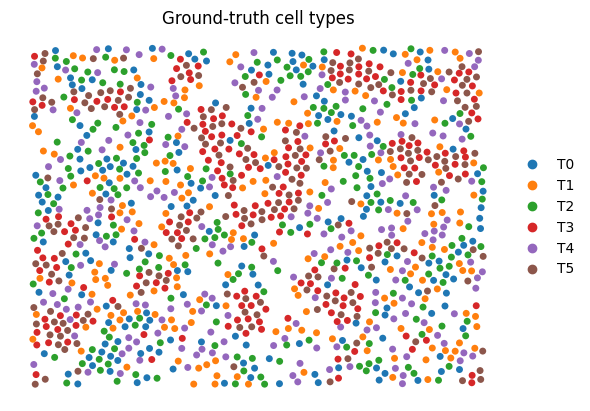

In [5]:
sc.pl.embedding(
    ad,
    basis="spatial",
    color="cell_type",
    title="Ground-truth cell types",
    frameon=False,
)

## 2. Build Spatial kNN Graph

We compute a *k*-nearest-neighbour graph directly from the (*x*, *y*)
coordinates.  The graph is stored in `ad.obsp["connectivities"]` and is used
by `nf.aggregate_neighbors` to collect neighbourhood compositions.

In [6]:
sc.pp.neighbors(ad, n_neighbors=5, use_rep="spatial")
print("connectivities shape:", ad.obsp["connectivities"].shape)

/Users/janpatrickpett/miniforge3/envs/nichefinder/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


connectivities shape: (1200, 1200)


## 3. Aggregate Neighbourhood Compositions

`nf.aggregate_neighbors` builds a *cell-type × cell-type* co-occurrence
matrix by summing the label vectors of all kNN neighbours for every
cell, and then stacking those sums across cells.

Setting `scale="expected"` divides each entry by the value expected under
random rewiring (i.e. proportional to marginal cell-type abundances), so the
matrix highlights cell-type pairs that are spatially enriched relative to a
random baseline.

In [7]:
agg_prob = nf.aggregate_neighbors(
    spatial=ad,
    label="cell_type",
    scale="expected",   # divide by random-rewiring baseline
)

print("agg_prob shape:", agg_prob.shape)
agg_prob

agg_prob shape: (6, 6)


,T0,T1,T2,T3,T4,T5
T0,1.022265,0.932342,2.120123,0.488750,0.951223,0.454788
T1,0.932342,1.399956,0.970566,0.582617,1.507932,0.566799
T2,2.120123,0.970566,0.982400,0.414062,0.974337,0.494591
T3,0.488750,0.582617,0.414062,1.204561,0.477976,2.903270
T4,0.951223,1.507932,0.974337,0.477976,1.429635,0.615443
T5,0.454788,0.566799,0.494591,2.903270,0.615443,1.058036


Text(0.5, 1.02, 'Aggregated neighbourhood compositions (scaled)')

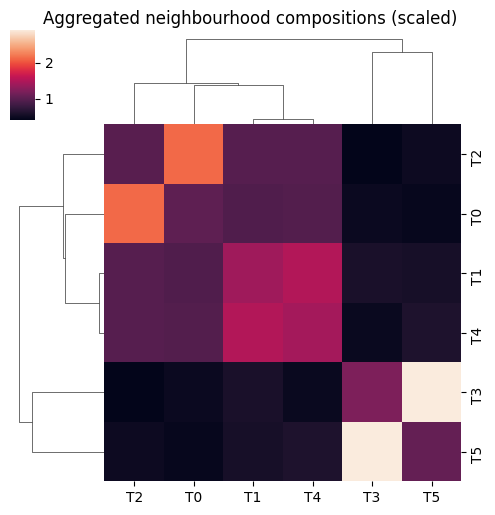

In [8]:
sns.clustermap(agg_prob, figsize=(5, 5))
plt.suptitle("Aggregated neighbourhood compositions (scaled)", y=1.02)

## 4. Find Niches (NMF)

`nf.find_niches` factorises the aggregated neighbour matrix using
Non-negative Matrix Factorisation (NMF): $A \approx W \cdot H$ and
then aggregate $W$ and $H$ into a single membership matrix $S$:
$S = 0.5 \cdot \hat{W} + 0.5 \cdot \hat{H}^T$.

where
- $A$ — cell-type × cell-type co-occurrence matrix (`agg_prob`)  
- $W$ — *membership* matrix (cell-types × niches): how much each cell type
  contributes to each niche  
- $H$ — *features* matrix (niches × cell-types): the cell-type composition
  characteristic of each niche

Setting `n_clusters=None` lets the function select the optimal number of
niches automatically via the elbow of the reconstruction-error curve
(up to `max_clusters`).

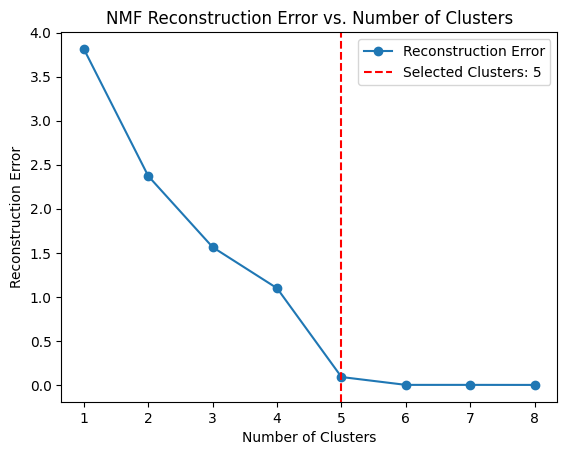

Selected number of niches: 5
Membership matrix (cell-types x niches):


,niche_0,niche_1,niche_2,niche_3,niche_4
T0,0.060609,0.075909,0.175061,0.350498,0.453779
T1,0.098380,0.093964,0.333980,0.106475,0.000000
T2,0.061812,0.069087,0.150537,0.419889,0.396587
T3,0.346026,0.321406,0.000000,0.011391,0.080366
T4,0.093475,0.087438,0.340110,0.110386,0.000214
T5,0.339697,0.352196,0.000312,0.001361,0.069054


Text(0.5, 1.02, 'Niche summary (cell-type x niche)')

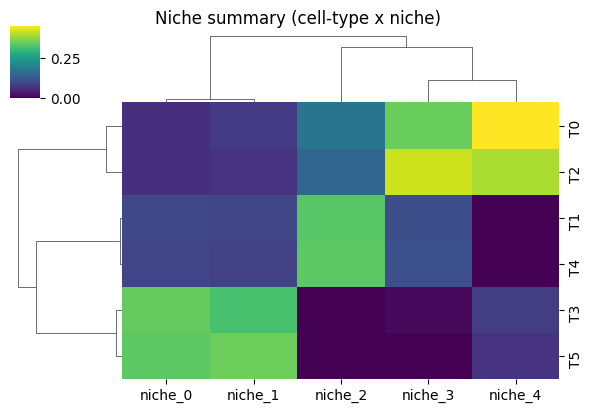

In [9]:
result = nf.find_niches(
    agg_prob,
    plot=True,          # plot reconstruction-error elbow curve
    n_clusters=None,    # auto-select via elbow
    max_clusters=8,
    return_dataframes=False,
)
print(f"Selected number of niches: {result.n}")

# symmetrize the factors into a single membership matrix
S = nf.symmetrise_nmf_factors(result.W, result.H)
niche_names = [f"niche_{i}" for i in range(result.n)]
summary = pd.DataFrame(S, index=agg_prob.index, columns=niche_names)

print("Membership matrix (cell-types x niches):")
display(summary)

sns.clustermap(summary, figsize=(6, 4), cmap="viridis")
plt.suptitle("Niche summary (cell-type x niche)", y=1.02)

## 5. Visualise Spatial Niches

### Aggregated interactions + niche overlay

`nf.plot_aggregated_neighbors` combines the co-occurrence heatmap with the
niche loadings in a single view.

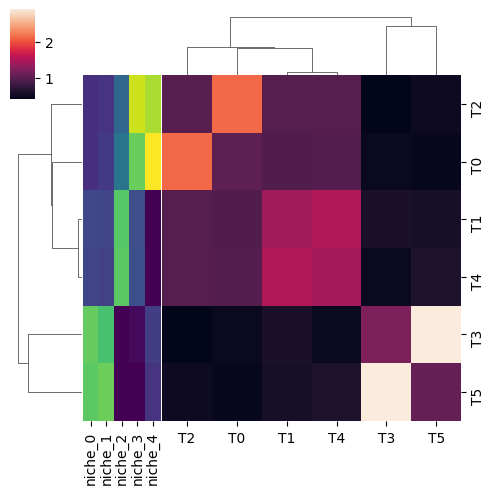

In [10]:
nf.plot_aggregated_neighbors(
    agg_prob,
    summary,
    figsize=(5, 5),
    colors_ratio=0.035,
    dendrogram_ratio=(0.15, 0.15),
)

### Niche bipartite graph

`nf.plot_niches` displays the niche–cell-type associations as a bipartite
graph.  Edges connect each niche to the cell types with membership weights
above `threshold`.

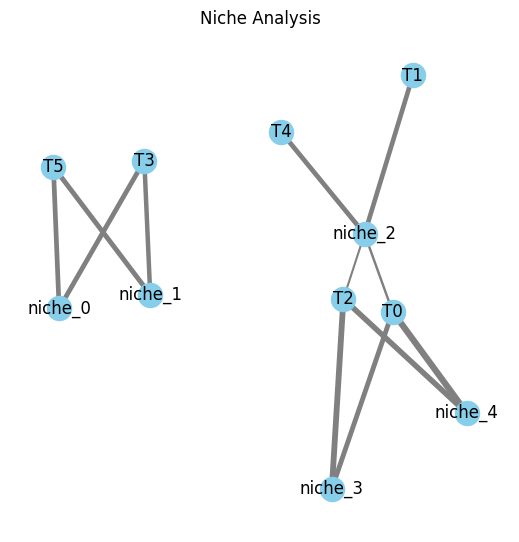

In [12]:
with plt.rc_context({"figure.figsize": (5, 5)}):
    nf.plot_niches(
        membership=summary,
        threshold=0.15,
        scale=None,
        edge_width_scale=10.0,
    )

## Summary

This tutorial walked through the core nichefinder workflow:

| Step | Function / method |
|------|-------------------|
| Load data | `pd.read_csv` → `sc.AnnData` |
| Spatial kNN graph | `sc.pp.neighbors(..., use_rep="spatial")` |
| Aggregate neighbourhoods | `nf.aggregate_neighbors` |
| Discover niches (NMF) | `nf.find_niches` |
| Visualise niche profiles | `nf.plot_aggregated_neighbors`, `nf.plot_niches` |

**Key parameters to tune:**

- `n_neighbors` — the spatial neighbourhood size  
- `scale` — how to normalise the co-occurrence matrix  
  (`"expected"`, `"expected_no_diag"`, `None`)  
- `n_clusters` / `max_clusters` — number of niches (or maximum for auto-selection)  

For real ISS data, replace the one-hot `cell_type_prob` matrix with
probabilistic label-transfer output from `nf.transfer_labels`.

## References

[1] Agrawal, A., Thomann, S., Basu, S. et al. NiCo identifies extrinsic drivers of cell state modulation by niche covariation analysis. Nat Commun 15, 10628 (2024). https://doi.org/10.1038/s41467-024-54973-w